<a href="https://colab.research.google.com/github/wowowo-wo/learning-25-01/blob/main/calc_obsdiam_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
def floyd_warshall(adj_matrix):
    n = len(adj_matrix)
    # 初期化: 隣接行列をそのまま使う（無限大は np.inf）
    dist = np.array(adj_matrix, dtype=float)

    dist[dist == 0] = np.inf  # 自己ループ以外の距離はinfにする
    np.fill_diagonal(dist, 0)  # 対角線（自己ループ）は0

    # フロイド・ワーシャル法で最短経路を計算
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    return dist

In [3]:
def remove_zero_weight_vertices(adj_matrix, vertex_weights):
    # 頂点重みが0の頂点を特定
    zero_weight_vertices = np.where(vertex_weights == 0)[0]

    # 新たな隣接行列を作成（コピーして作業）
    new_adj_matrix = np.copy(adj_matrix)

    # 頂点重みが0の頂点に関連する辺を削除
    for v in zero_weight_vertices:
        # 対象の頂点と関連する行と列を削除
        new_adj_matrix[v, :] = 0
        new_adj_matrix[:, v] = 0

    # さらに、頂点重みが0の頂点を隣接行列から削除
    new_adj_matrix = np.delete(new_adj_matrix, zero_weight_vertices, axis=0)
    new_adj_matrix = np.delete(new_adj_matrix, zero_weight_vertices, axis=1)

    # 新たな頂点重みの配列も更新
    new_vertex_weights = np.delete(vertex_weights, zero_weight_vertices)

    return new_adj_matrix, new_vertex_weights

In [4]:
def p_centered_diam(dist, vertex_weights, i, p):
    # 頂点iを中心とした重みの和が1-p以上となる最小半径dを求める

    n = len(dist)  # 頂点の数
    visited = [False] * n  # 訪れた頂点を記録するリスト
    weight_sum = vertex_weights[i]  # 最初はiの重みだけ
    d = 0  # 最初の距離は0

    # 重みの和が1-p以上になれば終了
    if weight_sum >= 1 - p:
        return d

    # iからの距離がd以下の頂点を探して、重みの和を更新していく
    visited[i] = True  # iはすでに訪れた
    while True:
        # 距離d以下の頂点の中で、まだ訪れていない頂点をすべてリストに集める
        candidates = []
        for j in range(n):
            if not visited[j] and dist[i][j] <= d:
                candidates.append(j)

        # 次に訪れるべき頂点を更新し、重みの和を加算
        for j in candidates:
            visited[j] = True
            weight_sum += vertex_weights[j]

        # 重みの和が1-p以上になれば終了
        if weight_sum >= 1 - p:
            return d

        # 次のdを、まだ訪れていない頂点の中で、最小の距離に更新
        min_dist = np.inf
        for j in range(n):
            if not visited[j] and dist[i][j] < min_dist:
                min_dist = dist[i][j]

        # 最小距離が更新されなければ終了
        if min_dist == np.inf:
            break

        # dを更新
        d = min_dist

    return d

In [5]:
def p_observable_diameter(dist, vertex_weights, p):
    # 全ての頂点に対してp_centered_diamを計算し、その最大値を返す

    n = len(dist)  # 頂点の数
    p_ovservable_diameter = -np.inf  # 初期化

    for i in range(n):
        # 各頂点iに対してp_centered_diamを計算
        diameter = p_centered_diam(dist, vertex_weights, i, p)

        # 最大値を更新
        if diameter > p_ovservable_diameter:
           p_ovservable_diameter = diameter

    return p_ovservable_diameter

In [6]:
def max_p_and_p_observable_diameter(dist, vertex_weights):

    n = len(vertex_weights)
    # p = 0, 1/10n, 2/10n, ..., 1 の間で p_observable_diameter と p の最大値を求める
    p_values = np.linspace(0, 1, 10 * n + 1)  # p = 0, 1/10n, ..., 1と離散化
    results = []

    for p in p_values:
        observable_diameter = p_observable_diameter(dist, vertex_weights, p)
        results.append(max(observable_diameter, p))

    return p_values, results

In [7]:
def observable_diameter(dist, vertex_weights):
    p_values, results = max_p_and_p_observable_diameter(dist, vertex_weights)

    # pに関する最小値を求める
    min_value = min(results)
    min_index = results.index(min_value)
    min_p = p_values[min_index]

    return min_p, min_value

In [8]:
# パラメータ設定
num_stocks = 25  # 銘柄数
days_per_year = 252  # 1年の日数（営業日）
years = 3  # データ期間（年）
total_days = days_per_year * years  # 合計日数
start_date = "2020-01-01"  # 開始日

# グループ設定（銘柄を複数グループに分ける）
num_groups = 5  # グループ数
group_size = num_stocks // num_groups
stock_groups = [f"Group_{i+1}" for i in range(num_groups)]

# 仮想的な銘柄名を生成し、それぞれのグループに割り当て
stocks = []
for i, group in enumerate(stock_groups):
    stocks.extend([(f"Stock_{chr(65 + i * group_size + j)}", group) for j in range(group_size)])

# 銘柄ごとの価格データを格納するリスト
all_data = []

# グループごとの共通要因を生成
np.random.seed(12)
group_factors = {group: np.random.normal(0, 0.01, total_days).cumsum() for group in stock_groups}

# 各銘柄のデータを生成
for stock, group in stocks:
    np.random.seed(hash(stock) % 2**32)  # 銘柄ごとに異なる乱数を設定
    dates = pd.date_range(start=start_date, periods=total_days, freq="B")  # 営業日

    # 銘柄固有のボラティリティと平均リターンを設定
    base_volatility = np.random.uniform(0.01, 0.05)  # ベースボラティリティ
    drift = np.random.uniform(-0.0002, 0.0005)  # 平均リターン

    # グループ共通要因と銘柄固有のトレンドを追加
    trend = np.linspace(0, np.random.uniform(-0.1, 0.1), total_days)
    group_effect = group_factors[group] * np.random.uniform(0.5, 1.5)
    seasonality = 0.01 * np.sin(2 * np.pi * np.arange(total_days) / days_per_year)  # 季節性

    # ランダムイベント（数日間の急激な変動）
    event_days = np.random.choice(total_days, size=5, replace=False)
    event_effects = np.zeros(total_days)
    for day in event_days:
        event_effects[day:day+3] += np.random.uniform(-0.1, 0.1)

    # 仮想的な価格データを生成
    prices = [100]  # 初期価格
    for t in range(1, total_days):
        daily_return = (
            np.random.normal(drift, base_volatility)
            + trend[t]
            + seasonality[t]
            + group_effect[t]
            + event_effects[t]
        )
        prices.append(prices[-1] * (1 + daily_return))

    # 長さを調整して価格データを生成
    open_prices = np.array(prices[:-1])
    close_prices = np.array(prices[1:])
    high_prices = close_prices * (1 + np.random.uniform(0, 0.02, size=len(close_prices)))
    low_prices = close_prices * (1 - np.random.uniform(0, 0.02, size=len(close_prices)))

    # 取引量を価格変動に連動させる（長さ調整）
    volatility = np.abs(np.diff(prices) / prices[:-1])
    volume = (1000 + (volatility * 100000)).astype(int)

    # データフレームを作成（長さを揃える）
    stock_data = pd.DataFrame({
        "Date": dates[1:],  # 価格データと一致させるため最初の行を削除
        "Stock": stock,
        "Group": group,
        "Open": open_prices,
        "High": high_prices,
        "Low": low_prices,
        "Close": close_prices,
        "Volume": volume
    })
    all_data.append(stock_data)

# 全銘柄のデータを結合
final_data = pd.concat(all_data, ignore_index=True)

# グループ情報を含む一覧を生成
group_mapping = pd.DataFrame(stocks, columns=["Stock", "Group"])

# 銘柄-グループ対応表を保存
group_mapping.to_csv("stock_group_mapping.csv", index=False)

# 銘柄データ全体も保存
final_data.to_csv("grouped_synthetic_stock_data.csv", index=False)

# 結果を表示
print("Group Mapping:")
print(group_mapping)

Group Mapping:
      Stock    Group
0   Stock_A  Group_1
1   Stock_B  Group_1
2   Stock_C  Group_1
3   Stock_D  Group_1
4   Stock_E  Group_1
5   Stock_F  Group_2
6   Stock_G  Group_2
7   Stock_H  Group_2
8   Stock_I  Group_2
9   Stock_J  Group_2
10  Stock_K  Group_3
11  Stock_L  Group_3
12  Stock_M  Group_3
13  Stock_N  Group_3
14  Stock_O  Group_3
15  Stock_P  Group_4
16  Stock_Q  Group_4
17  Stock_R  Group_4
18  Stock_S  Group_4
19  Stock_T  Group_4
20  Stock_U  Group_5
21  Stock_V  Group_5
22  Stock_W  Group_5
23  Stock_X  Group_5
24  Stock_Y  Group_5


In [9]:
# 全銘柄のデータを読み込む
# (前のコードで生成した `final_data` を使用)

# 銘柄リストを取得
stock_names = final_data['Stock'].unique()

# 各銘柄の終値データをピボット形式に変換
pivot_data = final_data.pivot(index='Date', columns='Stock', values='Close')

# 銘柄間の相関係数行列を計算
correlation_matrix = pivot_data.corr()
print(correlation_matrix)

Stock     Stock_A   Stock_B   Stock_C   Stock_D   Stock_E   Stock_F   Stock_G  \
Stock                                                                           
Stock_A  1.000000  0.985505  0.981884  0.943654  0.932711 -0.095878 -0.089960   
Stock_B  0.985505  1.000000  0.994069  0.963966  0.964247 -0.106400 -0.099832   
Stock_C  0.981884  0.994069  1.000000  0.982128  0.981392 -0.104776 -0.098309   
Stock_D  0.943654  0.963966  0.982128  1.000000  0.991436 -0.101723 -0.095444   
Stock_E  0.932711  0.964247  0.981392  0.991436  1.000000 -0.108964 -0.102238   
Stock_F -0.095878 -0.106400 -0.104776 -0.101723 -0.108964  1.000000  0.933099   
Stock_G -0.089960 -0.099832 -0.098309 -0.095444 -0.102238  0.933099  1.000000   
Stock_H -0.086785 -0.096310 -0.094840 -0.092076 -0.098630 -0.004385 -0.073857   
Stock_I -0.072090 -0.080001 -0.078780 -0.076485 -0.081929  0.027844 -0.049525   
Stock_J -0.080853 -0.089727 -0.088357 -0.085783 -0.091889  0.910287  0.993950   
Stock_K  0.065974  0.080500 

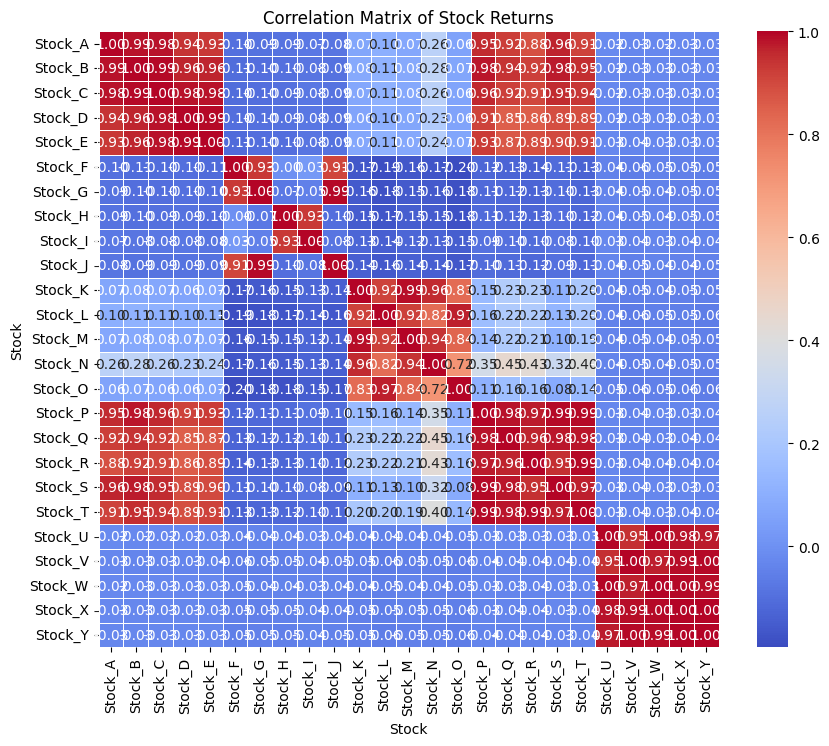

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Stock Returns")
plt.show()

In [20]:
# 構造の設定
# 重み付き隣接行列を計算
# 重み = -相関係数 + 1.01
adj_matrix = -correlation_matrix + 1.01

# 対角成分を0に設定
np.fill_diagonal(adj_matrix.values, 0)

# 隣接行列を表示
print("Adjacency Matrix:")
print(adj_matrix)# 隣接行列

vertex_weights = np.array([0.18 ,0.12 ,0, 0 ,0 ,
                           0 ,0 ,0.4 ,0 ,0 ,
                           0 ,0 ,0 ,0 ,0 ,
                           0 ,0 ,0.15 ,0 ,0 ,
                           0 ,0 ,0 ,0.15 ,0])  # 頂点重みベクトル

adj_matrix, vertex_weights = remove_zero_weight_vertices(adj_matrix, vertex_weights)


# 隣接行列から距離行列を計算
dist = adj_matrix
print(adj_matrix)

Adjacency Matrix:
Stock     Stock_A   Stock_B   Stock_C   Stock_D   Stock_E   Stock_F   Stock_G  \
Stock                                                                           
Stock_A  0.000000  0.024495  0.028116  0.066346  0.077289  1.105878  1.099960   
Stock_B  0.024495  0.000000  0.015931  0.046034  0.045753  1.116400  1.109832   
Stock_C  0.028116  0.015931  0.000000  0.027872  0.028608  1.114776  1.108309   
Stock_D  0.066346  0.046034  0.027872  0.000000  0.018564  1.111723  1.105444   
Stock_E  0.077289  0.045753  0.028608  0.018564  0.000000  1.118964  1.112238   
Stock_F  1.105878  1.116400  1.114776  1.111723  1.118964  0.000000  0.076901   
Stock_G  1.099960  1.109832  1.108309  1.105444  1.112238  0.076901  0.000000   
Stock_H  1.096785  1.106310  1.104840  1.102076  1.108630  1.014385  1.083857   
Stock_I  1.082090  1.090001  1.088780  1.086485  1.091929  0.982156  1.059525   
Stock_J  1.090853  1.099727  1.098357  1.095783  1.101889  0.099713  0.016050   
Stock_K  0

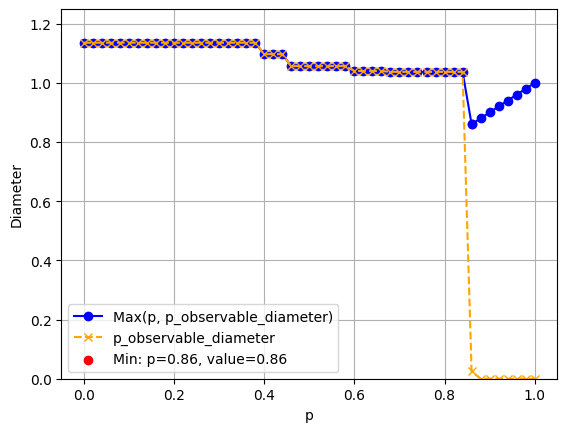

In [21]:
# max_p_and_p_observable_diameter を使って p に対する最大値を計算
p_values, results = max_p_and_p_observable_diameter(dist, vertex_weights)

# observable_diameter を使って最小値と対応するpを取得
min_p, min_value = observable_diameter(dist, vertex_weights)

# p_observable_diameter の結果を計算
observable_diameters = [p_observable_diameter(dist, vertex_weights, p) for p in p_values]

# プロット
plt.plot(p_values, results, marker='o', linestyle='-', color='b', label="Max(p, p_observable_diameter)")
plt.plot(p_values, observable_diameters, marker='x', linestyle='--', color='orange', label="p_observable_diameter")

# タイトルと軸ラベル
plt.xlabel("p")
plt.ylabel("Diameter")
plt.grid(True)

# 最小値に対応するpの位置に印をつける
plt.scatter(min_p, min_value, color='red', label=f"Min: p={min_p:.2f}, value={min_value:.2f}")

# 凡例の表示
plt.legend()

# y軸の範囲を0から最大値に設定（y軸が0を含むように）
plt.ylim(0, max(results) * 1.1)

# プロットを表示
plt.show()

In [22]:
min_p, min_value

(0.86, 0.86)